### Want to look at beliefs from fitted Belief State Agents on Sam's behavioral data, plot some points. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *

import seaborn as sns
import scipy


In [2]:
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [3]:
def load_session_data(row):
    sess_name = row.session_name

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
    beh = pd.read_csv(behavior_path)
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, sess_name)
    med = beh.BeliefStateValue.median()
    beh["BeliefStateValueBin"] = beh.apply(lambda x: 0 if x.BeliefStateValue < med else 1, axis=1)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["BeliefLabel"] = beh.apply(lambda x: f"High Value Pref {x.PreferredBelief}" if x.BeliefStateValueBin == 1 else "Low Value", axis=1)
    beh["session"] = sess_name
    return beh

In [4]:
all_beh = sessions.apply(lambda row: load_session_data(row), axis=1)
all_beh = pd.concat(all_beh.values)

In [5]:
all_beh

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,YELLOWProb,ESCHERProb,POLKADOTProb,RIPPLEProb,SWIRLProb,BeliefStateValue,BeliefStateValueBin,PreferredBelief,BeliefLabel,session
0,49,2,0,NaN,2258,Incorrect,2.0,11,SQUARE,SWIRL,...,0.083333,0.083333,0.083333,0.083333,0.083333,0.328915,0,CIRCLE,Low Value,20180709
1,50,2,1,NaN,1881,Incorrect,2.0,11,SQUARE,SWIRL,...,0.040750,0.097528,0.040750,0.097528,0.097528,0.331893,0,SQUARE,Low Value,20180709
2,51,2,2,NaN,2206,Incorrect,3.0,11,SQUARE,SWIRL,...,0.056439,0.110206,0.056439,0.110206,0.046048,0.334192,0,ESCHER,Low Value,20180709
3,52,2,3,NaN,2005,Correct,0.0,11,SQUARE,SWIRL,...,0.072522,0.124313,0.072522,0.124313,0.026120,0.335530,0,SQUARE,Low Value,20180709
4,53,2,4,NaN,1834,Correct,0.0,11,SQUARE,SWIRL,...,0.057577,0.090212,0.057577,0.090212,0.067819,0.338974,0,SQUARE,Low Value,20180709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,876,26,13,NaN,2654,Correct,0.0,4,CYAN,GREEN,...,0.014386,0.042511,0.016779,0.023828,0.026757,0.509555,1,CYAN,High Value Pref CYAN,20180910
854,877,26,14,NaN,2557,Correct,0.0,4,CYAN,GREEN,...,0.014097,0.026026,0.015112,0.043323,0.019344,0.526579,1,CYAN,High Value Pref CYAN,20180910
855,878,26,15,NaN,2696,Correct,0.0,4,CYAN,GREEN,...,0.013645,0.018585,0.014065,0.025749,0.037857,0.533984,1,CYAN,High Value Pref CYAN,20180910
856,879,26,16,NaN,2567,Correct,0.0,4,CYAN,GREEN,...,0.013433,0.037037,0.013607,0.018437,0.023442,0.540309,1,CYAN,High Value Pref CYAN,20180910


<Axes: xlabel='SQUAREProb', ylabel='CIRCLEProb'>

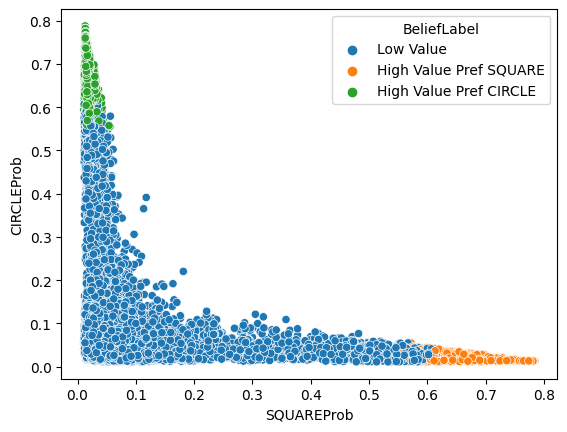

In [6]:
feat1 = "SQUARE"
feat2 = "CIRCLE"
sub_res = all_beh[all_beh.BeliefLabel.isin(["Low Value", f"High Value Pref {feat1}", f"High Value Pref {feat2}"])]
fig, ax = plt.subplots()
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="BeliefLabel", ax=ax)

<Axes: xlabel='SQUAREProb', ylabel='CIRCLEProb'>

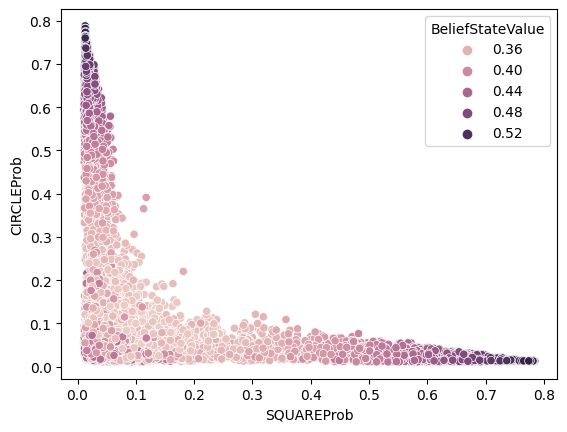

In [7]:
feat1 = "SQUARE"
feat2 = "CIRCLE"
sub_res = all_beh[all_beh.BeliefLabel.isin(["Low Value", f"High Value Pref {feat1}", f"High Value Pref {feat2}"])]
fig, ax = plt.subplots()
sns.scatterplot(sub_res, x=f"{feat1}Prob", y=f"{feat2}Prob", hue="BeliefStateValue", ax=ax)

### How to Belief State Values and Feature Entropies relate? (different models)

In [10]:
def load_session_data_beliefs_and_ent(row):
    sess_name = row.session_name

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
    beh = pd.read_csv(behavior_path)
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, sess_name)

    beh = behavioral_utils.get_feature_values_per_session(sess_name, beh)
    beh = behavioral_utils.get_max_feature_value(beh)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh)
    beh = behavioral_utils.calc_confidence(beh, num_bins=2, quantize_bins=True)
    beh["session"] = sess_name
    return beh

In [11]:
all_beh = sessions.apply(lambda row: load_session_data_beliefs_and_ent(row), axis=1)
all_beh = pd.concat(all_beh.values)

Text(0, 0.5, 'Belief State Value')

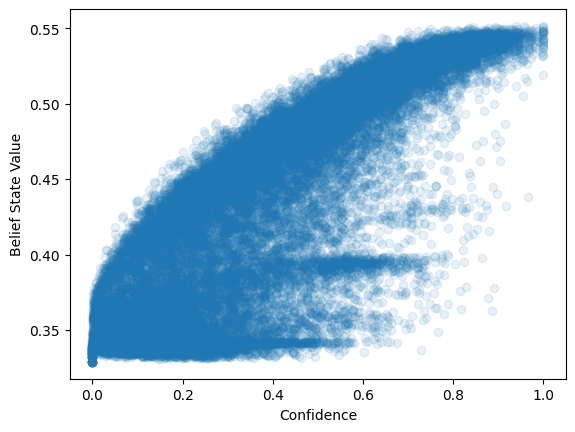

In [12]:
fig, ax = plt.subplots()
ax.scatter(all_beh["Confidence"], all_beh["BeliefStateValue"], alpha=0.1)
ax.set_xlabel("Confidence")
ax.set_ylabel("Belief State Value")